# Libraries

In [20]:
# Types
from  matplotlib.axes import Axes
from  plotly.graph_objs import Figure
from pandas import DataFrame
from typing import Callable

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
import seaborn as sns

# Visualization Functions

## Dropdown Plotter
Given a map of [function name -> function references] and a Dataframe plot an interactive graph that switches plots with a dropdown

In [21]:
def dropdown_plotter(df:DataFrame, viz_map:dict[str,Callable[DataFrame,Figure]], height:int=600, width:int=800):
    """Display an interactive Plotly chart with a dropdown menu to switch between different visualizations.

    Parameters:
        - df: The DataFrame to visualize.
        - viz_map: Dictionary where keys are dropdown names and values are functions that return Plotly traces/layout updates.
        - height: Height of the figure pixels.
        - width: Width of the figure pixels.
    """

    # Generate all figures
    figures = {name: func(df) for name, func in viz_map.items()}
    fig_keys = list(figures.keys())

    # Create a combined figure that will hold all traces
    master_fig = go.Figure()

    # Track how many traces each figure has
    trace_counts = []
    for i, key in enumerate(fig_keys):
        fig = figures[key]
        visible = (i == 0)
        for trace in fig.data:
            trace.visible = visible
            master_fig.add_trace(trace)
        trace_counts.append(len(fig.data))

    # Create dropdown buttons
    buttons = []
    trace_start = 0
    for i, key in enumerate(fig_keys):
        trace_count = trace_counts[i]
        visibility = [False] * len(master_fig.data)
        for j in range(trace_count):
            visibility[trace_start + j] = True

        trace_start += trace_count

        # Get layout and fix axis type if histogram
        fig_layout = figures[key].layout.to_plotly_json()
        is_hist = any(trace.type == 'histogram' for trace in figures[key].data)
        xaxis_config = fig_layout.get("xaxis", {})
        if is_hist:
            xaxis_config["type"] = "linear"

        buttons.append(dict(
            label=key,
            method="update",
            args=[
                {"visible": visibility},
                {
                    "title": fig_layout.get("title", {}),
                    "xaxis": xaxis_config,
                    "yaxis": fig_layout.get("yaxis", {})
                }
            ]
        ))

    # Set layout from first figure
    first_fig_layout = figures[fig_keys[0]].layout

    master_fig.update_layout(
        updatemenus=[
            dict(
                type="dropdown",
                active=0,
                buttons=buttons,
                x=0.5,
                xanchor="center",
                y=1.2,
                yanchor="top",
                pad={"r": 10, "t": 10},
                showactive=True
            )
        ],
        title=first_fig_layout.title,
        xaxis=first_fig_layout.xaxis,
        yaxis=first_fig_layout.yaxis,
        margin=dict(t=150),
        height=height,
        width=width
    )

    pio.show(master_fig)


### Usage

In [22]:
# Load example dataset
df = sns.load_dataset("iris")

# Define Plotly visualizations
def scatter_plot(df:DataFrame):
    fig = px.scatter(df, x="sepal_length", y="sepal_width", color="species", title="Sepal Scatter")
    return fig

def box_plot(df:DataFrame):
    fig = px.box(df, x="species", y="petal_length", title="Petal Length Boxplot")
    return fig

def hist_plot(df:DataFrame):
    fig = px.histogram(df, x="sepal_length", nbins=20, title="Sepal Length Histogram")
    return fig

# Map of named visualizations
viz_map = {
    "Scatter Plot": scatter_plot,
    "Histogram": hist_plot,
    "Box Plot": box_plot,
}

# Call interactive function
dropdown_plotter(df, viz_map)


## Grid Plotter

Given a list of function references and a Dataframe plot them in a grid format

In [23]:
def gid_plotter(df:DataFrame, viz_functions:list, cols:int=2, figsize:tuple[int,int]=(12, 8)):
    """Plot a grid of visualizations based on the provided functions.

    Parameters:
        - df: The DataFrame to visualize.
        - viz_functions: A list of functions. Each function should take a single Axes object and the df as arguments.
        - cols: Number of columns in the grid.
        - figsize: Overall figure size.
    """
    
    n = len(viz_functions)
    rows = math.ceil(n / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Flatten axes array for easy indexing
    if rows == 1 and cols == 1:
        axes = [axes]
    elif rows == 1 or cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.ravel()

    for i, viz_fn in enumerate(viz_functions):
        viz_fn(axes[i], df)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


### Usage Example

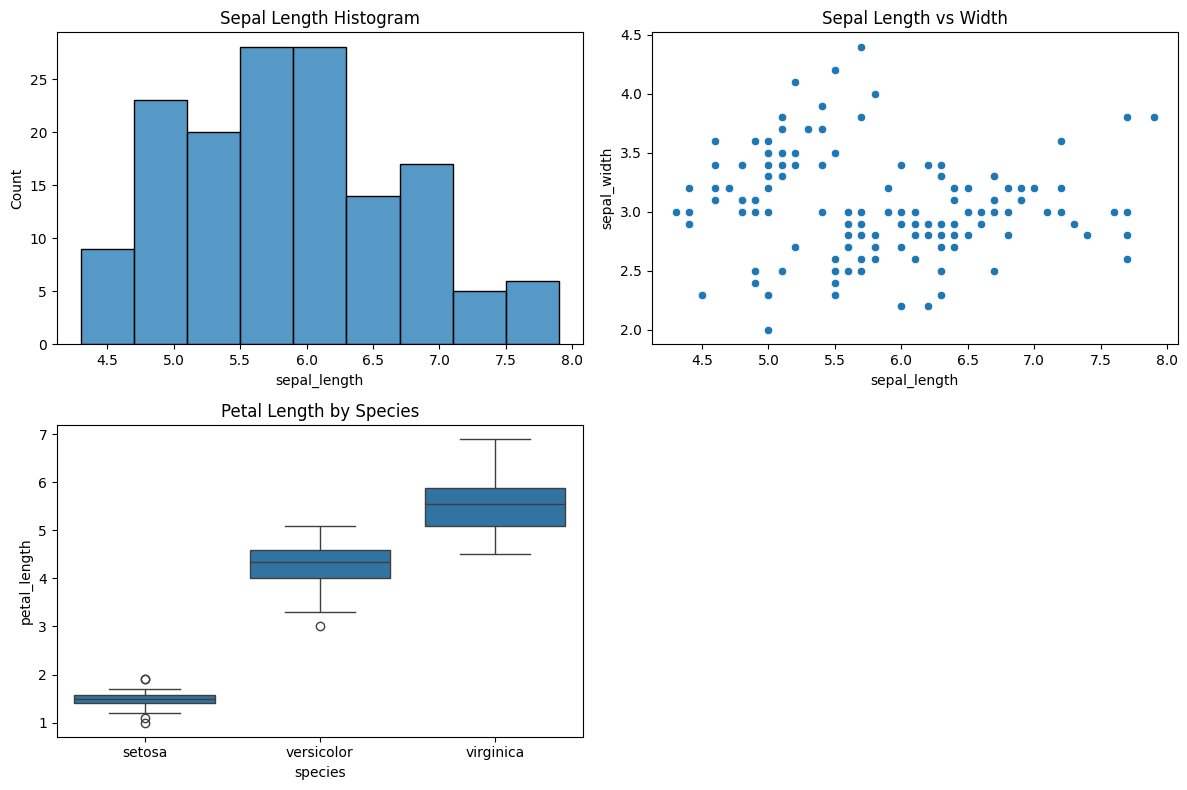

In [24]:
# Sample DataFrame
df = sns.load_dataset("iris")

# Example visualizations
def plot_hist(ax:Axes, df:DataFrame):
    sns.histplot(df["sepal_length"], ax=ax)
    ax.set_title("Sepal Length Histogram")

def plot_scatter(ax:Axes, df:DataFrame):
    sns.scatterplot(x="sepal_length", y="sepal_width", data=df, ax=ax)
    ax.set_title("Sepal Length vs Width")

def plot_box(ax:Axes, df:DataFrame):
    sns.boxplot(x="species", y="petal_length", data=df, ax=ax)
    ax.set_title("Petal Length by Species")

# Plot grid
gid_plotter(df, [plot_hist, plot_scatter, plot_box], cols=2)
